In [1]:
from IPython.display import Image
from IPython.core.display import HTML
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp
from sympy.plotting import plot
import operator
from scipy.special import roots_laguerre

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Functions for plotting and solving ODE's

In [51]:
# Returns a list of points (2-tuples) for each solution to the system of equations.
# If the nullclines are on top of each other, this method may produce unexpected results.
def nullcline_intersection(sys):
    t, x, y = sp.symbols('t, x, y')
    eq1 = sys[0](t, x, y)
    eq2 = sys[1](t, x, y)
    sols = sp.solve([eq1, eq2], [x, y])
    return sols

def plot_nullclines(sys, linx, liny):
    t, x, y = sp.symbols('t, x, y')
    eq1 = sys[0](t, x, y)
    eq2 = sys[1](t, x, y)
    
    nullcline_x = sp.solve(eq2,x )[0] #x = f(y)
    nullclines = plot(nullcline_x)
    
    return nullclines
    

# sys is as above, x_window and y_window are lists/tuples containing the ranges for the window.
# ex: plot_flow(sys, [0, 10], [5, 15]) goes from 0 to 10 on the x axis and 5 to 15 on the y axis.
def plot_flow(sys, x_window, y_window, num_arrows, t=0):
    
    linx = np.linspace(x_window[0], x_window[1], num_arrows)
    liny = np.linspace(y_window[0], y_window[1], num_arrows)
    X, Y = np.meshgrid(linx, liny)
    
    Xa = sys[0](t, X, Y)
    Ya = sys[1](t, X, Y)
    
    n = np.sqrt(Xa*Xa + Ya*Ya)
    plt.title('Slope Field and Nullcline Intersections');
    plt.quiver(X, Y, Xa/n, Ya/n, color='g');
    
    #intersections = nullcline_intersection(sys)
    #for pt in intersections:
    #    print(f'Intersection at: {pt}')
    #    plt.plot([0], pt[1], 'bo');
        
    
    #nullcline_y = sp.solve(Xa,x)[0] #y = f(x)
    #print(nullcline_y)       
    #p1 = plot_nullclines(sys, linx, liny)
    
        
# Generates the numerical solution to an Initial Value Problem. Returns a tuple of all the times that the system was sampled at
# and a list of the corresponding states.
# sys    - list of 2 functions to solve
# init   - list of initial values for the system
# tspan  - list of beginning time and ending time
# h      - step size
# stopfn - a function that takes two arguments, time and the current state of the system. When the lambda returns a truthy value 
#          the solver will halt.
def solve_IVP(sys, init, tspan, h=None, is_forward=None):
    
    def compare(a, relate, b):
        return relate(a,b)
      
    # Check for span errors
    if tspan[0] == tspan[1]:
        print('Please make the timespan a list of two distinct values.')
    
    def wrap(sys):
        def F(t,state):
            return np.array([sys[0](t, state[0], state[1]), sys[1](t, state[0], state[1])])
        return F
    
    def rk4(t,y,h,func):
        k1 = h*func(t,y)
        k2 = h*func(t+0.5*h,y+0.5*k1)
        k3 = h*func(t+0.5*h,y+0.5*k2)
        k4 = h*func(t+h,y+k3)
        return (k1 + 2*k2 + 2*k3 + k4) / 6
    
    def rk4_solve(t0,tf,h,y0,func,relation):
        # print('(t0,tf,h,y0,func,stopfn)')
        # print(t0,tf,h,y0,func,stopfn)
        tv, yv, = [], [] # Results
        t, y = t0, y0 # Current state
        
        while (compare(t,relation,tf)):
            y += rk4(t,y,h,func) 
            t += h
            yv.append(y.copy())
            tv.append(t)
        return np.array(tv), np.array(yv)
    
    return rk4_solve(tspan[0], tspan[1], h, init, wrap(sys), is_forward)


def plot_IVP(sys, init, tspan, h=None, is_forward=None):
    # Choose the missing parameters
    forward = tspan[1] > tspan[0]
    if is_forward == None:    
        is_forward = operator.lt if forward else operator.gt
        print(f'Choosing stopping method {"forward" if forward else "backward"}.')
    if h == None:
        h = .01 if forward else -.01
        print(f'Choosing step size {h}.')
    t,v = solve_IVP(sys, init, tspan, h, is_forward)
    plt.plot(v[:,0],v[:,1],'y--');
    #plt.plot(init[0], init[1], 'r.')
    return t,v

# Taylor approximation at x0 of the function 'function'. The degree of the resulting polynomial is n.
def taylor(function,x0,n):
    x, y = sp.symbols('x, y')
    eq = function(x, y)
    
    def factorial(n):
        return 1 if n <= 0 else n*factorial(n-1)
    i = 0
    p = 0
    while i <= n:
        p = p + (eq.diff(x,i).subs(x,x0))/(factorial(i))*(x-x0)**i
        i += 1
    return sp.simplify(p)

In [3]:
def plot_time_series(sys, init, tspan, h=None, is_forward=None):
    # Choose the missing parameters
    forward = tspan[1] > tspan[0]
    if is_forward == None:    
        is_forward = operator.lt if forward else operator.gt
        print(f'Choosing stopping method {"forward" if forward else "backward"}.')
    if h == None:
        h = .01 if forward else -.01
    print(f'Choosing step size {h}.')
    t,v = solve_IVP(sys, init, tspan, h, is_forward)
    plt.plot(t,v[:,1],'y--');
    plt.plot(t[0], init[1], 'r.')
    plt.xlabel('$t$',size=20)
    return t,v

# Linearizing the System using the Jacobian

In [4]:
# Returns a matrix of functions in the first variable of the system and the second variable of the system.
def jacobian(sys, t=0):
    def to_func(s):
        return eval(f'lambda t, x, y : {s.__repr__()}')
    x, y = sp.symbols('x, y')
    x_eq = sys[0](t, x, y)
    y_eq = sys[1](t, x, y)
    jac = [ [ sp.Derivative(x_eq, x).doit(), sp.Derivative(x_eq, y).doit() ], [ sp.Derivative(y_eq, x).doit(), sp.Derivative(y_eq, y).doit()] ]
    fnr1 = [ to_func(e) for e in jac[0] ]
    fnr2 = [ to_func(e) for e in jac[1] ]
    return [fnr1, fnr2]

# Creates the jacobian for the system and solves it at the point (x, y) at a certain point in time.
def jacobian_at_a_point(sys, x, y, t=0):
    jac = jacobian(sys, t)
    return eval_jacobian(jac, t, x, y)

# x - value for first variable
# y - value for second variable
def eval_jacobian(jac, t, x, y):
    return [[float(jac[0][0](t,x,y)),float(jac[0][1](t,x,y))],[float(jac[1][0](t,x,y)),float(jac[1][1](t,x,y))]]

def print_jacobian(sys):
    t, x, y = sp.symbols('t, x, y')
    x_eq = sys[0](t, x, y)
    y_eq = sys[1](t, x, y)
    jac = [ [ sp.Derivative(x_eq, x).doit(), sp.Derivative(x_eq, y).doit() ], [ sp.Derivative(y_eq, x).doit(), sp.Derivative(y_eq, y).doit()]]
    print(jac)
    return jac


# Gauss Laguerre Quadrature:

$\int_{0}^{+\infty} e^{-x} f(x) d x \approx \sum_{i=1}^{n} w_{i} f\left(x_{i}\right)$

In [5]:
def gauss_laguerre_quadrature(f,conversion,N):
    
    x,w = roots_laguerre(N)
    
    #need to become e^(-x)
    x=x*conversion
    w=w*conversion

    return sum(f(x)*w)

# Ramsey Model - original functions

In [6]:
Image(url= "https://media.discordapp.net/attachments/719942223730573342/724636646808617022/unknown.png")

In [7]:
sys = [lambda t, k,c : k**0.5 - c, lambda t, k,c : 0.5*c*(k)**(-0.5) - 0.1*c]

### forward-solve:

Choosing stopping method forward.
Choosing step size 0.01.


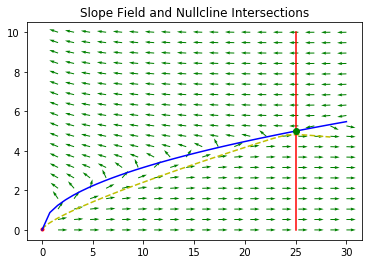

In [8]:
plot_flow(sys, [0, 30], [0, 10], 20)

#solving forward:
tf = 74

plot_IVP(sys, [0.01285009, 0.02446086], [0, tf]);

#add isoclines:
k = np.linspace(0,30,40)
c = np.sqrt(k) # dk = sqrt(k) - c with dk = 0
# dc = 0 implies 0.5/sqrt(k) - 0.1 = 0 so k = 25
plt.plot(k,c,'b',[25,25],[0,10],'r',25,5,'go');

### backward-solve:

Choosing stopping method backward.
Choosing step size -0.01.


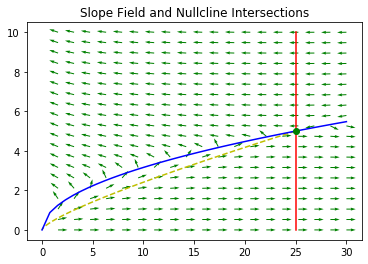

In [9]:
plot_flow(sys, [0, 30], [0, 10], 20)

k0 = 25
error = 0.01
c0 = 5-error
tf =300 

plot_IVP(sys, [k0, c0], [tf, 0]);

#add isoclines:
k = np.linspace(0,30,40)
c = np.sqrt(k) # dk = sqrt(k) - c with dk = 0
# dc = 0 implies 0.5/sqrt(k) - 0.1 = 0 so k = 25
plt.plot(k,c,'b',[25,25],[0,10],'r',25,5,'go');

In [10]:
print("The general jacobian matrix is:")
print_jacobian(sys)
print()

sol = nullcline_intersection(sys)
print("The Jacobian at the equilibrium point is:")
print(jacobian_at_a_point(sys, sol[0][0], sol[0][1]))

The general jacobian matrix is:
[[0.5*x**(-0.5), -1], [-0.25*x**(-1.5)*y, 0.5*x**(-0.5) - 0.1]]

The Jacobian at the equilibrium point is:
[[0.1, -1.0], [-0.01, 0.0]]


# Ramsey Model - Barro adds depreciation and some discounting

In [11]:
Image(url= "https://cdn.discordapp.com/attachments/719942223730573342/724636873003237499/unknown.png")

In [12]:
#use plot vector field
#k is x, c is y
#sys = [ lambda t, k, c : k**0.5 - c, lambda t, k, c : 0.5 * c * k**(-0.5) - 0.1*c ]
α = .5; δ=.1; ρ=.05; β=.5
k_prime = lambda t, k, c : k**(α) - c - δ*k
c_prime = lambda t, k, c : c*(α*k**(α-1) - δ - (ρ/β))
sys = [k_prime, c_prime]

Choosing stopping method backward.
Choosing step size -0.01.


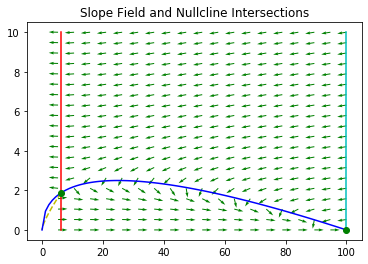

In [13]:
plot_flow(sys, [0, 100], [0, 10], 20)

#backward solves the system:
tf = 200
t, v = plot_IVP(sys, [6.25, 1.875-.01], [tf,0]);

k = np.linspace(0,100,90)
isocline_c = lambda k : k**α - δ*k
plt.plot(k,isocline_c(k),'b',[6.25,6.25],[0,10],'r',[100,100],[0,10],'c',100,0,'go',6.25,1.875,'go');


# Barro's Modification of the Ramsey Function

### Barro adds present bias and commitment technologies (sorta) by adding 𝜆, which is solved for here:

##### we can approximate Ω which is defined as:

$\Omega=e^{-(b / \gamma)} \int_{0}^{\infty} e^{(b / \gamma)\left(e^{-\gamma v}\right)} e^{-\rho v} d v$

##### And adding n for the effective workers we get:

$\Omega \equiv \int_{0}^{\infty} e^{-[(\rho-n) v+\phi(v)]} d v$
 
##### where 𝜙(𝑣)  is defined as:

$\phi(v)=(b / \gamma) \cdot\left(1-e^{-\gamma v}\right)$ 

which represents present bias.

### lambda is then solved for like this:

$\lambda=n+(1 / \Omega)$

more technically, 𝜆 represents the "effective" rate of time preference, effective implying we are linearlizing the time preference to find its approximation i.e. how much present bias is effecting our decision. It will be a lot in the short term and less in the long term.

and where 

${ρ ≤ 𝜆 ≤ ρ+𝜙'(0)}$ 

and $ρ$ would be our general appreciation without present bias

𝜆 plays a role in finding the steady state solutions for $\dot{k}$ and $\dot{c}$, which are defined as:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho-b e^{-\gamma(t-\tau)}\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

To find the steady state solutions, each equation is set equal to zero, and $\rho-b e^{-\gamma(t-\tau)}$ is replaced with either $\lambda$ or $\rho$ within the first equation, $\dot{c}$, depending on whether we are solving the short-term or long-term steady state solution

When solving using $\lambda$ (for the short-term steady state solution):

$\dot{c}=0=\alpha k^{\alpha-1}-\delta-x-\lambda$

we are also solving for what is known as the no commitment steady state. This is because, in the short term, it is like there is no commitment technologies effecting the present bias, so the present bias $\lambda$ is very present. This results in the short-term capital steady state,  $k_{0}^{*}$, and the short_term consumption steady state,  $c_{0}^{*}$

when solving using $\rho$ (for the long-term steady state solution):

$\dot{c}=0=\alpha k^{\alpha-1}-\delta-x-\rho$

we are also solving for what is known as the full commitment steady state. This is because, in the long term, present bias is no longer effective and it disapears, becoming the base amount of utility that we can foresee from the capital without present bias affecting our judgement, $\rho$.

This also means that $\left(k_{\infty}^{*}-k_{0}^{*}\right) / k_{0}^{*}$ is the relative measure between our long-term capital and our short-term capital. In other words, this is the difference between our long-term steady state and our short-term steady state of capital. The same applies to the relative measure of consumption,  $\left(c_{\infty}^{*}-c_{0}^{*}\right) / c_{0}^{*}$ .


##### Full commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho-b e^{-\gamma(t-\tau)}\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

##### No commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\lambda\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

In [14]:
full_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-ρ-b*np.exp(-γ*(t-τ)))]
no_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-λ)]

##### Barro adds present bias and commitment technologies (sorta)

In [15]:
#γ, b, ρ, δ, x, α, τ, n, λ = 0.5, 0.5, 0.02, 0.05, 0.01, 0.75, 0.0, 0.01, 0.036528

α = 0.75 # modifies the output function, as in how much output we get out given our capital
δ = 0.05 # represents the depreciation of capital
x = 0.02 # represents the cost of technological upkeep
b = 0.5  # b represents the upper bound of present bias
ρ = 0.02 # represents the amount of base utility we get without present bias affecting it
γ = 0.5  # represents how effective present bias is (in the short-term)
τ = 0.0  # represents the current day, where τ=0 means time starts today 
n = 0.01 # represents the cost of effective worker upkeep
λ = 0.036528 # represents present bias

In [16]:
# for use of the Gauss-Laguerre Quadrature when solving for lambda:
# f(x) = e^(-phi'(v))
def f(x):
    return np.exp( -((b/γ)*(1-np.exp(-γ*x))))

In [17]:
N=100
data = [[0.75,0.75,0.75, 0.33, 0.33, 0.33],
        [ 0.5, 0.2, 0.1,  0.5,  0.2,  0.1],
        [],
        [],
        []]

λ_data = []
b_data = data[1]

kinf_steady = []
cinf_steady = []
k0_steady = []
c0_steady = []

for b in b_data:
    convertWith = 1/(ρ-n)
    Ω = gauss_laguerre_quadrature(f,convertWith,N)
    λ = n + 1/Ω
    λ_data.append(λ)
data[2] = λ_data

alpha = data[0]
k_relative_measure = []
c_relative_measure = []

for i in range(6):
    kinf = ((δ+x+ρ)/alpha[i])**(1/(alpha[i]-1))
    cinf = kinf**alpha[i]-(δ+x+n)*kinf
    kinf_steady.append(kinf)
    cinf_steady.append(cinf)
    #print(kinf)
    #print(cinf)
    
    k0=((δ+x+λ_data[i])/alpha[i])**(1/(alpha[i]-1))
    c0 = k0**alpha[i]-(δ+x+n)*k0
    k0_steady.append(k0)
    c0_steady.append(c0)
    print(k0)
    
    k_rm = (kinf-k0)/k0
    c_rm = (cinf-c0)/c0
    k_relative_measure.append(k_rm)
    c_relative_measure.append(c_rm)
        
data[3] = k_relative_measure
data[4] = c_relative_measure

table = pd.DataFrame(data[:5], columns=["(1)","(2)","(3)","(4)","(5)","(6)"], 
                     index = ["α","b = φ'(0)", "λ", 
                              '<img src="https://cdn.discordapp.com/attachments/557363729759469578/726067490941304932/unknown.png" alt="img">', 
                              '<img src="https://cdn.discordapp.com/attachments/557363729759469578/726084138192339024/unknown.png" alt="img">'])
display(HTML(table.to_html(escape=False)))

2456.879512180132
3918.897833585466
4385.244486560167
5.406403052896017
6.4353567827629705
6.711084858183185


,(1),(2),(3),(4),(5),(6)
α,0.750000,0.750000,0.750000,0.330000,0.330000,0.330000
b = φ'(0),0.500000,0.200000,0.100000,0.500000,0.200000,0.100000
λ,0.036528,0.024792,0.022164,0.036528,0.024792,0.022164
,0.962868,0.230583,0.099718,0.286139,0.080497,0.036104
,0.265594,0.061101,0.025718,0.020842,0.004795,0.002006


In [18]:
# for use of the Gauss-Laguerre Quadrature when solving for lambda:
# f(x) = e^(-phi'(v))
def f(x):
    return np.exp( -((b/γ)*(1-np.exp(-γ*x))))

In [19]:
i=0 #location in the table
α=alpha[i]
λ = λ_data[i]
b = b_data[i]
print(.25*k0_steady[i])

614.219878045033


# Forward Solve the system of equations given c0 and k0: 

614.219878045033
Choosing stopping method forward.
Choosing step size 0.01.
Choosing stopping method forward.
Choosing step size 0.01.


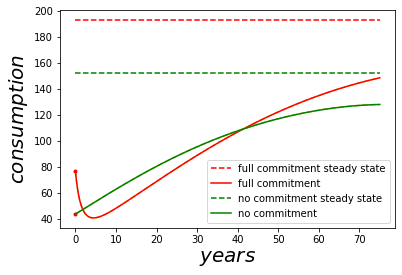

In [36]:
full_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-ρ-b*np.exp(-γ*(t-τ)))]
no_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-λ)]

#γ, b, ρ, δ, x, α, τ, n, λ = 0.5, 0.5, 0.02, 0.05, 0.01, 0.75, 0.0, 0.01, 0.036528

α = 0.75 # modifies the output function, as in how much output we get out given our capital
δ = 0.05 # represents the depreciation of capital
x = 0.02 # represents the cost of technological upkeep
b = 0.5  # b represents the upper bound of present bias
ρ = 0.02 # represents the amount of base utility we get without present bias affecting it
γ = 0.5  # represents how effective present bias is (in the short-term)
τ = 0.0  # represents the current day, where τ=0 means time starts today 
n = 0.01 # represents the cost of effective worker upkeep
λ = 0.036528 # represents present bias

i=0 #location in the table
α=alpha[i]
λ = λ_data[i]
b = b_data[i]
print(.25*k0_steady[i])

#k0 = 0.25*k_steady
k0 = 614.22
tf = 75

#full commitment:
plt.plot([0,tf], [cinf_steady[i], cinf_steady[i]], 'r--', label="full commitment steady state")

c0 = 77
t, v = plot_time_series(full_commitment, [k0,c0],[0,tf]);
plt.plot(t,v[:,1], 'r', label="full commitment")

#no commitment
plt.plot([0,tf], [c0_steady[i], c0_steady[i]], 'g--', label="no commitment steady state")

c0 = 43.8
t,v = plot_time_series(no_commitment,[k0,c0],[0,tf]);
plt.plot(t,v[:,1], 'g', label="no commitment")

# make the graph prettier
plt.xlabel('$years$',size=20)
plt.ylabel('$consumption$',size=20);
plt.legend();


[2412.95716417  128.09610493]


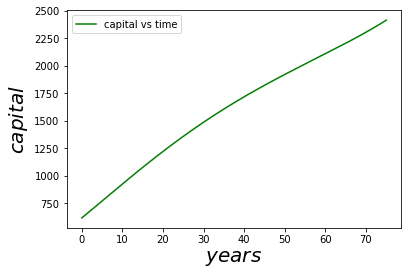

In [21]:
# To plot capital, plot v[:,0] instead of v[:,1]

plt.plot(t,v[:,0], 'g', label="capital vs time")
plt.legend()
plt.xlabel('$years$',size=20)
plt.ylabel('$capital$',size=20);
print(v[-1])

# Backward solve the system of equations:

##### (my intuition here: the tf used seems to decide what our c0 values will be)

In [22]:
# full commitment


Choosing stopping method backward.
Choosing step size -0.01.
[k(0), c(0)] for full commitment is currently [614.22389376  77.50690443]

Choosing stopping method backward.
Choosing step size -0.01.
[k(0), c(0)] for no commitment is currently [614.22745154  43.89260327]


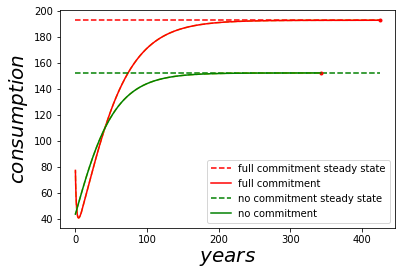

In [23]:
# solve for the systems of equations for c0:
error = 0.01

#full commitment
tf= 424.774
#tf = 79.5764

plt.plot([0,tf], [cinf_steady[i], cinf_steady[i]], 'r--', label="full commitment steady state")

init_pt = [kinf_steady[i], cinf_steady[i]-error]
t, v = plot_time_series(full_commitment, init_pt,[tf,0])
plt.plot(t,v[:,1], 'r', label="full commitment")
full_commit_c0 = v[-1][1]
print(f'[k(0), c(0)] for full commitment is currently {v[-1]}')
print()

#no commitment
plt.plot([0,tf], [c0_steady[i], c0_steady[i]], 'g--', label="no commitment steady state")
tf= 342.489
#tf = 79.5764

init_pt = [k0_steady[i], c0_steady[i]-error] #short-term steady state - no commitment

t, v = plot_time_series(no_commitment, init_pt, [tf,0])
plt.plot(t,v[:,1], 'g', label="no commitment")
no_commit_c0 = v[-1][1]
print(f'[k(0), c(0)] for no commitment is currently {v[-1]}')

# make the graph prettier
plt.legend();
plt.xlabel('$years$',size=20)
plt.ylabel('$consumption$',size=20);


### Plugging the resulting c0 values into the forward solver (which decides the shape of the graphs) but not the k0 value, which should always be .25 $k^{*}_{0}$:

##### we want the curve to follow the steady state and not shoot off into infinity or to zero

Choosing stopping method forward.
Choosing step size 0.01.
[k(75), c(75)] for full commitment is currently [3602.20614479  157.61115922]

Choosing stopping method forward.
Choosing step size 0.01.
[k(75), c(75)] for no commitment is currently [2157.76892178  135.6901256 ]


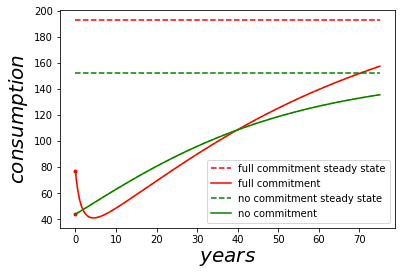

In [24]:
tf= 75
init_k0 = .25*k0_steady[0]
error = 0.01

#full commitment
plt.plot([0,tf], [cinf_steady[i], cinf_steady[i]], 'r--', label="full commitment steady state")

t, v = plot_time_series(full_commitment, [init_k0, full_commit_c0], [0,tf])
plt.plot(t,v[:,1], 'r', label="full commitment")
print(f'[k({tf}), c({tf})] for full commitment is currently {v[-1]}')
print()

#no commitment
plt.plot([0,tf], [c0_steady[i], c0_steady[i]], 'g--', label="no commitment steady state")

t, v = plot_time_series(no_commitment, [init_k0,  no_commit_c0],[0,tf])
#t, v = plot_IVP(no_commitment, [init_k0,  no_commit_c0],[0,tf])
plt.plot(t,v[:,1], 'g', label="no commitment")
print(f'[k({tf}), c({tf})] for no commitment is currently {v[-1]}')

# make the graph prettier
plt.legend();
plt.xlabel('$years$',size=20)
plt.ylabel('$consumption$',size=20);


# Using the Time-elimination method:

This is easy for no commitment since no commitment does not contain time in its equations, but this will be tricky for full commitment.

In [1]:
full_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-ρ-b*np.exp(-γ*(t-τ)))]
no_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-λ)]

## Using the Jacobian

the intuition here, as I understand it, is that zooming into the equilbrium points can help us get a better understanding of the functions. Also, using the Jacobian is the process of normalizing our functions, which should also help us understand our functions better. Viewing the Jacobian flow plot is also like viewing the time-elimination graph. For instance, for no commitment, the equation didn't need to be modified, but for full commitment, the equation was modified by getting rid of b*np.exp(-γ*(t-τ)), reducing the equation to $\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho\right)$

##### Full commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho-b e^{-\gamma(t-\tau)}\right)
\mbox{   becomes   } \dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\rho\right)\\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

##### No commitment:

$ \begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-x-\lambda\right) \\
\dot{k}=k^{\alpha}-c-(\delta+x+n) k
\end{array}$

##### No Commitment:

In [96]:
#setting up the flow plots for the Jacobian graphs
num_arrows = 20
xmin = -5; xmax = 5
umin = -5; umax = 5
kk = np.linspace(xmin, xmax, num_arrows)
cc = np.linspace(umin, umax, num_arrows)
K, C = np.meshgrid(kk, cc)

The general jacobian matrix is:
[[0.75*x**(-0.25) - 0.08, -1], [-0.1875*x**(-1.25)*y, 0.75*x**(-0.25) - 0.106528374122304]]

Using the equilibrium point (2456.87951218015, 152.419478821522)

The Jacobian at the equilibrium point is:
[[0.056528374122304006, -1.0], [-0.0016521973486011096, 0.016528374122304013]]

Choosing stopping method backward.
Choosing step size -0.01.
Choosing stopping method backward.
Choosing step size -0.01.


c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


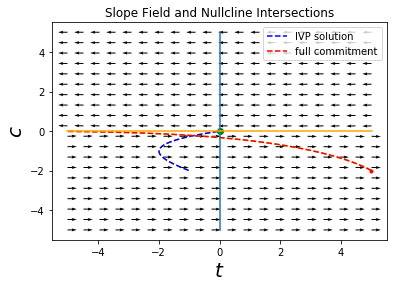

In [168]:
print("The general jacobian matrix is:")
print_jacobian(no_commitment)
print()

sol = nullcline_intersection(no_commitment)
print(f'Using the equilibrium point {sol[0]}\n')


no_commit_jacobian_at_equilibrium = jacobian_at_a_point(sys, sol[0][0], sol[0][1])
print(f'The Jacobian at the equilibrium point is:\n{no_commit_jacobian_at_equilibrium}\n')

y = np.array([0,0])
A = np.array(no_commit_jacobian_at_equilibrium)
eq = np.linalg.solve(A,y)

#plot flow of Jacobian
f = no_commit_jacobian_at_equilibrium[0][1]*C
g = no_commit_jacobian_at_equilibrium[1][0]*K
normalizer = 1/np.sqrt(f**2+g**2)
plt.quiver(K,C,f*normalizer,g*normalizer)

#plot solution
#backward_init_pt = [k0_steady[i], c0_steady[i]-error] #short-term steady state - no commitment
#no_commit_forward_init_pt = [init_k0, no_commit_c0]

#plotting the IVP
tf = 10
t, v = plot_IVP(no_commitment, [-1,-2], [tf,0])
plt.plot(v[:,0],v[:,1],'b--', label="IVP solution");


#time series plot
t, v = plot_time_series(no_commitment, [-1,-2], [5,-5])
plt.plot(t,v[:,1], 'r--', label="full commitment")

plt.plot(eq[0],eq[1],'go')
plt.xlabel('$t$',size=20)
plt.ylabel('$c$',size=20)
plt.plot([0,0],[-5,5],[-5,5],[0,0],'orange')
plt.title("Slope Field and Nullcline Intersections")
plt.legend();

#####  Full Commitment:

The general jacobian matrix is:
[[0.75*x**(-0.25) - 0.08, -1], [-0.1875*x**(-1.25)*y, 0.75*x**(-0.25) - 0.106528374122304]]

Using the equilibrium point (4822.53086419753, 192.901234567901)

The Jacobian at the equilibrium point is:
[[0.039999999999999994, -1.0], [-0.0009000000000000002, 0.0]]

Choosing stopping method backward.
Choosing step size -0.01.
Choosing stopping method backward.
Choosing step size -0.01.


c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\student\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


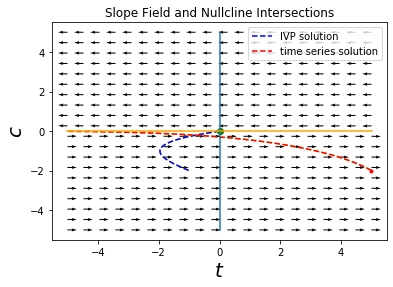

In [166]:
#full_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-ρ-b*np.exp(-γ*(t-τ)))]
full_commitment = [lambda t, k,c : k**α-c-(δ+x+n)*k, lambda t, k,c : c*(α*k**(α-1)-δ-x-ρ)]

print("The general jacobian matrix is:")
print_jacobian(no_commitment)
print()

sol = nullcline_intersection(full_commitment)
print(f'Using the equilibrium point {sol[0]}\n')


commit_jacobian_at_equilibrium = jacobian_at_a_point(sys, sol[0][0], sol[0][1])
print(f'The Jacobian at the equilibrium point is:\n{commit_jacobian_at_equilibrium}\n')

y = np.array([0,0])
A = np.array(no_commit_jacobian_at_equilibrium)
eq = np.linalg.solve(A,y)

#plot flow of Jacobian
g = commit_jacobian_at_equilibrium[1][0]*K
f = commit_jacobian_at_equilibrium[0][1]*C
normalizer = 1/np.sqrt(f**2+g**2)
plt.quiver(K,C,f*normalizer,g*normalizer);

#plot solution
#backward_init_pt = [k0_steady[i], c0_steady[i]-error] #short-term steady state - no commitment
#full_commit_forward_init_pt = [init_k0, full_commit_c0]

#plotting the IVP
tf = 10
t, v = plot_IVP(full_commitment, [-1,-2], [tf,0])
plt.plot(v[:,0],v[:,1],'b--', label="IVP solution");

#plotting the time series graph
t, v = plot_time_series(full_commitment, [-1,-2], [5,-5])
plt.plot(t,v[:,1], 'r--', label="time series solution")

#plotting the equilibrium point and making the graph pretty
plt.plot(eq[0],eq[1],'go')
plt.xlabel('$t$',size=20)
plt.ylabel('$c$',size=20)
plt.plot([0,0],[-5,5],[-5,5],[0,0],'orange')
plt.title("Slope Field and Nullcline Intersections")
plt.legend();